In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sensitivity_tests import *
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import os

from gurobipy import *
setParam("OutputFlag", 0)

Academic license - for non-commercial use only


In [3]:
ELO_var = [1, 10, 20, 30]
n_instances = 1000
n_trials = 500
n_items = 14

In [4]:
CSV_FILENAME = "sensitivity_dataset_elo.csv"
def write_chunk(dataset):
    if dataset == []:
        return
    df = pd.DataFrame(dataset)
    if not os.path.isfile(CSV_FILENAME):
        df.to_csv(CSV_FILENAME, mode='a', index=False)
    elif len(df.columns) != len(pd.read_csv(CSV_FILENAME, nrows=1).columns):
        raise Exception("Columns do not match!! Dataframe has " +
                        str(len(df.columns)) + " columns. CSV file has " +
                        str(len(pd.read_csv(CSV_FILENAME, nrows=1).columns)) + " columns.")
    else:
        target_columns = list(pd.read_csv(CSV_FILENAME, nrows=1).columns)
        source_columns = df.columns
        if not all([(col in target_columns) for col in source_columns]):
            raise Exception("Columns of dataframe and csv file do not match!!")
        df[target_columns].to_csv(CSV_FILENAME, mode='a', index=False, header=False)

In [5]:
dataset = []
instances_per_chunk = 10

for instance_idx in tqdm(range(n_instances)):
    data_source = SynthELOTournamentSource(n_items, n_games=5, comp_var=ELO_var[instance_idx%len(ELO_var)])
    dataset.append(ProblemInstance(data_source).collect_data(num_random_restarts=500,n_sensitivity_trials=n_trials))
    if (instance_idx + 1) % instances_per_chunk == 0:
        write_chunk(dataset)
        dataset = []
write_chunk(dataset)

100%|██████████| 1000/1000 [11:07:02<00:00, 40.02s/it] 


In [6]:
df = pd.read_csv(CSV_FILENAME)
sensitivities = [col for col in df.columns if "mean_sensitivity" in col]
sensitivities

['mean_sensitivity(LOPRankingAlgorithm,SwapNoise(0.05))',
 'mean_sensitivity(LOPRankingAlgorithm,BinaryFlipNoise(0.05))',
 'mean_sensitivity(MasseyRankingAlgorithm,SwapNoise(0.05))',
 'mean_sensitivity(MasseyRankingAlgorithm,BinaryFlipNoise(0.05))',
 'mean_sensitivity(ColleyRankingAlgorithm,SwapNoise(0.05))',
 'mean_sensitivity(ColleyRankingAlgorithm,BinaryFlipNoise(0.05))']

In [7]:
df["overall_mean_sensitivity"] = df[sensitivities].mean(axis=1)

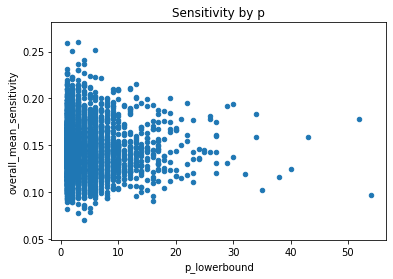

In [8]:
df.plot.scatter("p_lowerbound", "overall_mean_sensitivity", title="Sensitivity by p")

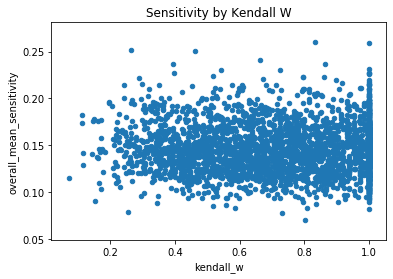

In [9]:
df.plot.scatter("kendall_w", "overall_mean_sensitivity", title="Sensitivity by Kendall W")

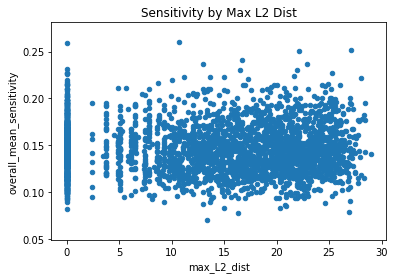

In [10]:
df.plot.scatter("max_L2_dist", "overall_mean_sensitivity", title="Sensitivity by Max L2 Dist")

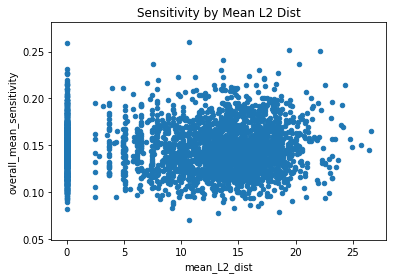

In [11]:
df.plot.scatter("mean_L2_dist", "overall_mean_sensitivity", title="Sensitivity by Mean L2 Dist")

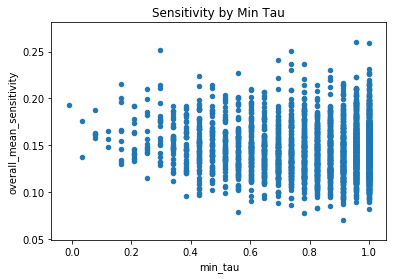

In [12]:
df.plot.scatter("min_tau", "overall_mean_sensitivity", title="Sensitivity by Min Tau")

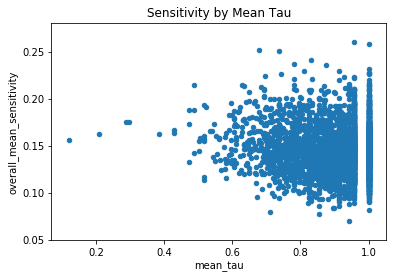

In [13]:
df.plot.scatter("mean_tau", "overall_mean_sensitivity", title="Sensitivity by Mean Tau")

In [14]:
def plot_taus(rankability_vals, taus, method_name, scatter_alpha=0.01, histogram_bins=30, save_dir="rankability_figures_run5"):
    # Create directory for saving if specified
    saving = False
    if save_dir is not None and save_dir != "":
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        saving = True
    
    # Plot scatter plot
    plt.scatter(rankability_vals, taus, alpha=scatter_alpha)
    title = "%s Sensitivity Scatter" % method_name
    plt.title(title)
    plt.xlabel('Rankability')
    plt.xlim(0.0, 1.0)
    plt.ylabel('Tau')
    plt.ylim(-1.0, 1.0)
    if saving:
        save_path = os.path.join(save_dir, title.replace(" ", "_") + ".png")
        plt.savefig(save_path)
    plt.show()
    
    # Plot 2D Histogram
    plt.hist2d(rankability_vals, taus, bins=histogram_bins, range=[[0.0, 1.0], [-1.0, 1.0]])
    title = "%s Sensitivity Histogram" % method_name
    plt.title(title)
    plt.xlabel('Rankability')
    plt.ylabel('Tau')
    if saving:
        save_path = os.path.join(save_dir, title.replace(" ", "_") + ".png")
        plt.savefig(save_path)
    plt.show()